# Pink Noise is 1/f noise

This simulator will generate pink noise and attempt to mitigate it using wavelets and gaussian processes

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"]      = 300
rcParams["figure.dpi"]       = 300
rcParams['errorbar.capsize'] = 0.0

from matplotlib.colors import LogNorm
from __future__ import absolute_import, unicode_literals, print_function
import pymultinest
import math
import os
import threading, subprocess

from astroML.plotting import hist

from sys import platform

from pylab import *;ion()

from time import time

from pymultinest.solve import Solver,solve

if not os.path.exists("chains"): os.mkdir("chains")

from celerite import plot_setup
plot_setup.setup()

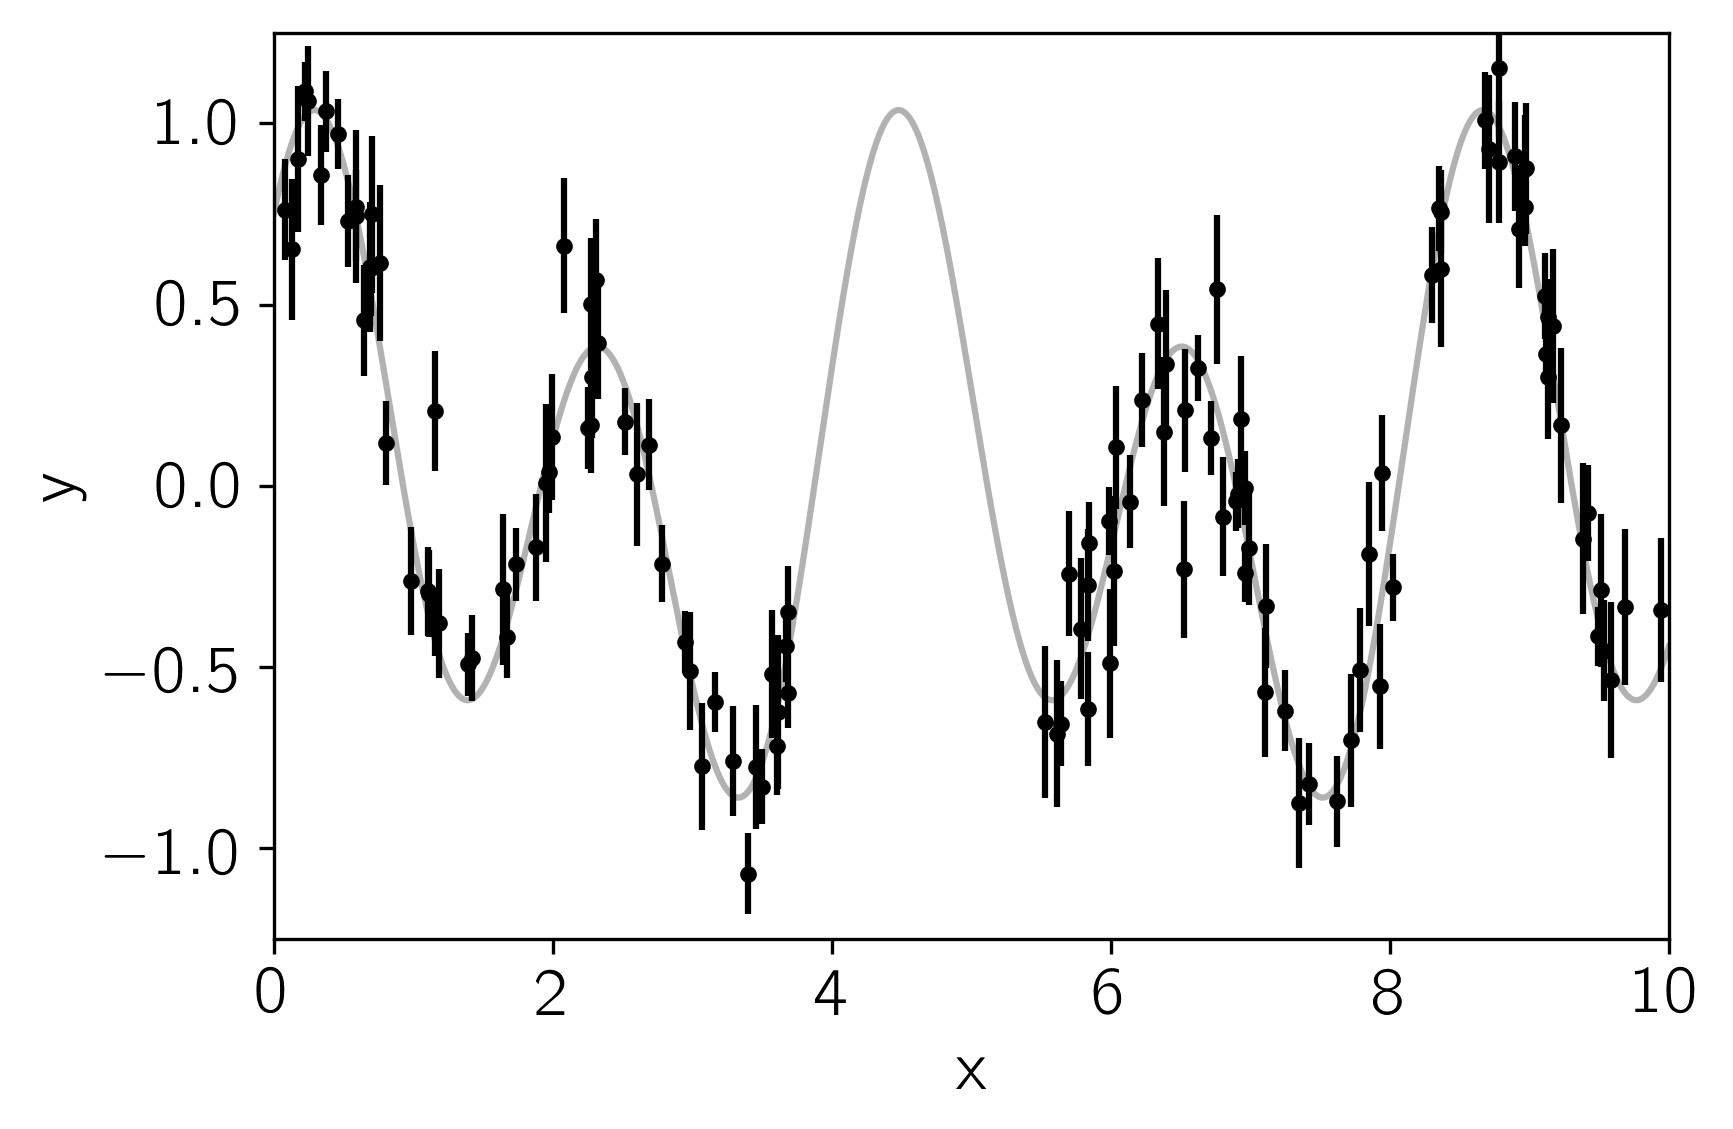

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

def quasi_periodic_oscillation(abscissa, coeffs, phaseOffset = 5):
    assert(len(coeffs) == 4)
    t = abscissa
    c = coeffs
    po= phaseOffset
    return c[0] * (t-po) + c[1]*np.sin(c[2]*t + c[3]*(t-po)**2) + c[4]*np.cos(c[2]*t + c[3]*(t-po)**2)

def fourier_function(abscissa, coeffs):
    assert(len(coeffs) == 3)
    t = abscissa
    c = coeffs
    return c[0]*np.sin(c[1]*t) + c[2]*np.cos(c[1]*t) 

t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
# y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

params1 = [.5, 3,.5]
params2 = [.25, 3/2,.25]

true_t = np.linspace(0, 10, 5000)
# true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

true_y = fourier_function(true_t, params1)+fourier_function(true_t, params2)
y = fourier_function(t, params1)+fourier_function(t, params2) + yerr * np.random.randn(len(t))

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-1.25, 1.25);

# Gaussian Processes

**Gaussian Processes with Celerite "first" example**

https://github.com/dfm/celerite/blob/master/docs/_static/notebooks/first.ipynb

**Pink Noise Generator**

https://github.com/python-acoustics/python-acoustics/blob/master/acoustics/generator.py

**Gaussian Processes for 1D Gaussian Fitting**

**SHOTerm PSD**

$$S(\omega) = \sqrt{\frac{2}{\pi}} \frac{S_0\,\omega_0^4}
    {(\omega^2-{\omega_0}^2)^2 + {\omega_0}^2\,\omega^2/Q^2}$$
    
**Real Term PSD**
$$k(\tau) = a_j\,e^{-c_j\,\tau}$$

In [3]:
def ms(x):
    """Mean value of signal `x` squared.
    :param x: Dynamic quantity.
    :returns: Mean squared of `x`.
    
    Source: https://github.com/python-acoustics/python-acoustics/blob/master/acoustics/generator.py
    """
    return (np.abs(x)**2.0).mean()

In [4]:
def normalize(y, x=None):
    """normalize power in y to a (standard normal) white noise signal.
    Optionally normalize to power in signal `x`.
    #The mean power of a Gaussian with :math:`\\mu=0` and :math:`\\sigma=1` is 1.
    
    Source: https://github.com/python-acoustics/python-acoustics/blob/master/acoustics/generator.py
    """
    #return y * np.sqrt( (np.abs(x)**2.0).mean() / (np.abs(y)**2.0).mean() )
    if x is not None:
        x = ms(x)
    else:
        x = 1.0
    return y * np.sqrt( x / ms(y) )
    #return y * np.sqrt( 1.0 / (np.abs(y)**2.0).mean() )
    ## Broken? Caused correlation in auralizations....weird!

In [5]:
def pink(N, state=None):
    """
    Pink noise. 
    
    :param N: Amount of samples.
    :param state: State of PRNG.
    :type state: :class:`np.random.RandomState`
    
    Pink noise has equal power in bands that are proportionally wide.
    Power density decreases with 3 dB per octave.
    
    Source: https://github.com/python-acoustics/python-acoustics/blob/master/acoustics/generator.py
    """
    state = np.random.RandomState() if state is None else state
    uneven = N%2
    X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
    S = np.sqrt(np.arange(len(X))+1.) # +1 to avoid divide by zero
    y = (irfft(X/S)).real
    if uneven:
        y = y[:-1]
    return normalize(y),S

In [76]:
np.random.seed(42)

nPts    = 1000
tinky   = linspace(0,10,nPts)

rstate = np.random.RandomState()
pinky , Sinky   = pink(nPts, state=rstate)
pinky2, Sinky2  = pink(nPts, state=rstate)

ginky   = np.random.normal(0,1,nPts)
pinkyC  = pinky + ginky

pinkystd = std(diff(pinky))
yerrMin  = 0.5*pinkystd
yerrMax  = 2*pinkystd
yerrinky = np.random.uniform(yerrMin, yerrMax, len(tinky))

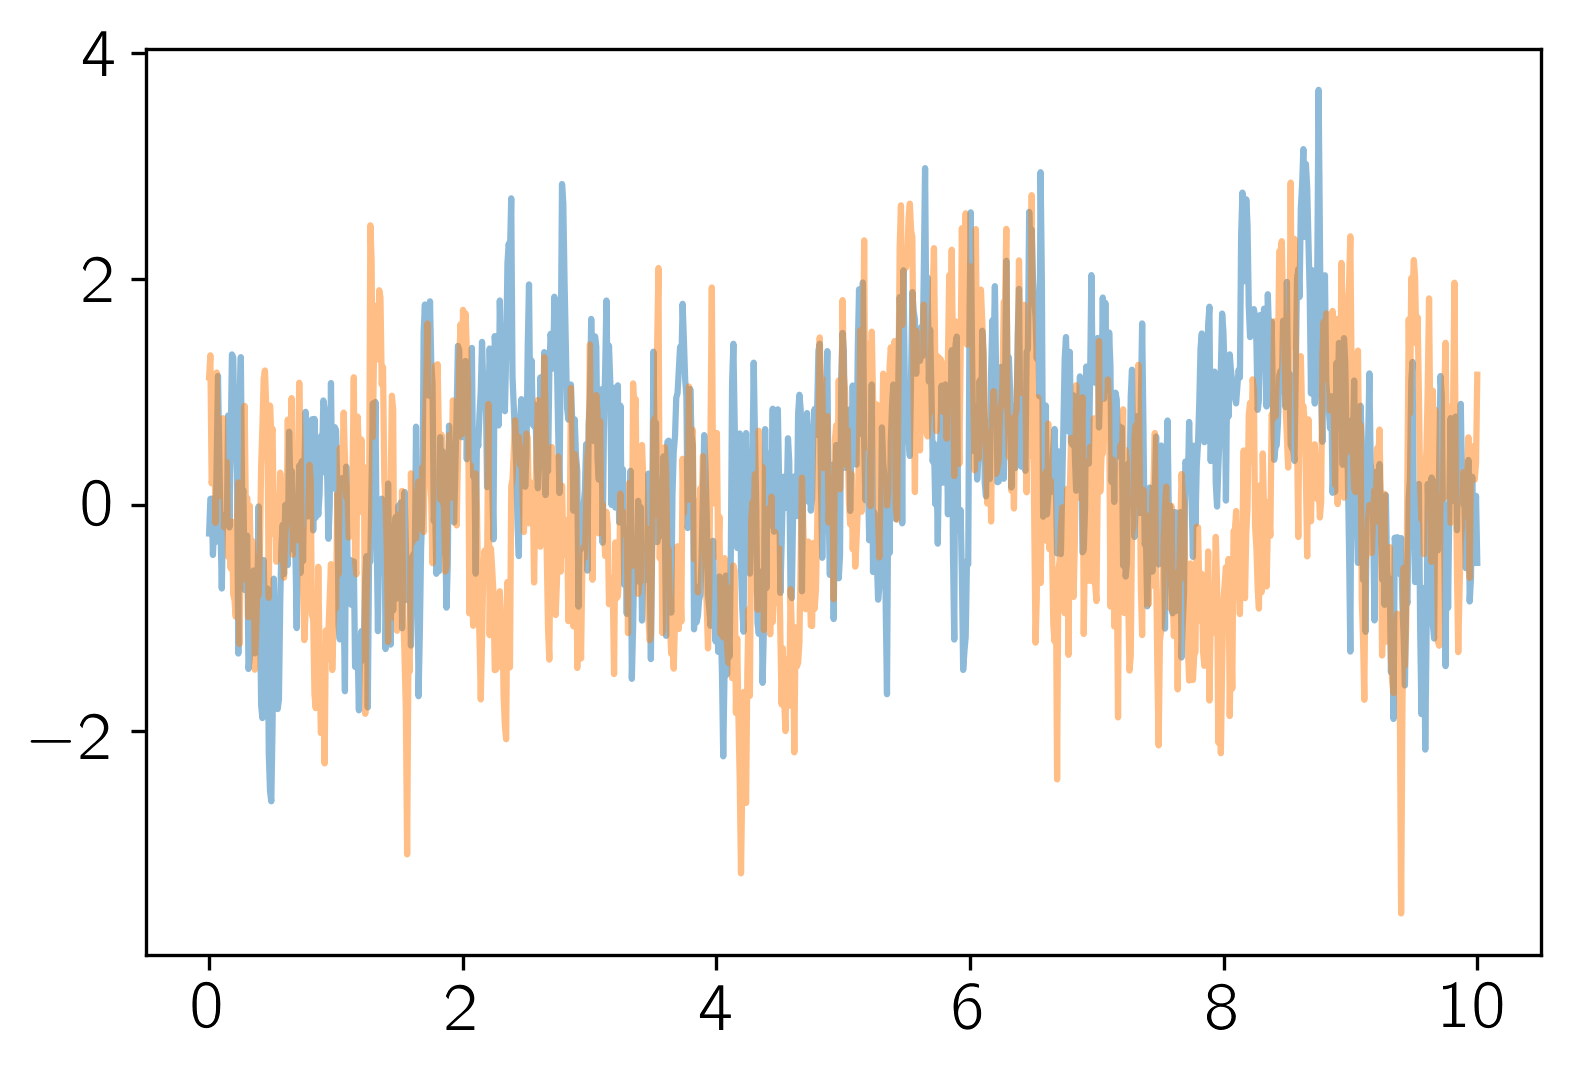

In [77]:
plt.plot(tinky,pinky,alpha=0.5);
plt.plot(tinky,pinky2,alpha=0.5);
# plt.plot(tinky[1:],np.diff(pinky),alpha=0.5);
# plt.plot(tinky[1:],np.diff(pinky2),alpha=0.5);
# plt.plot(tinky,ginky,alpha=0.5);

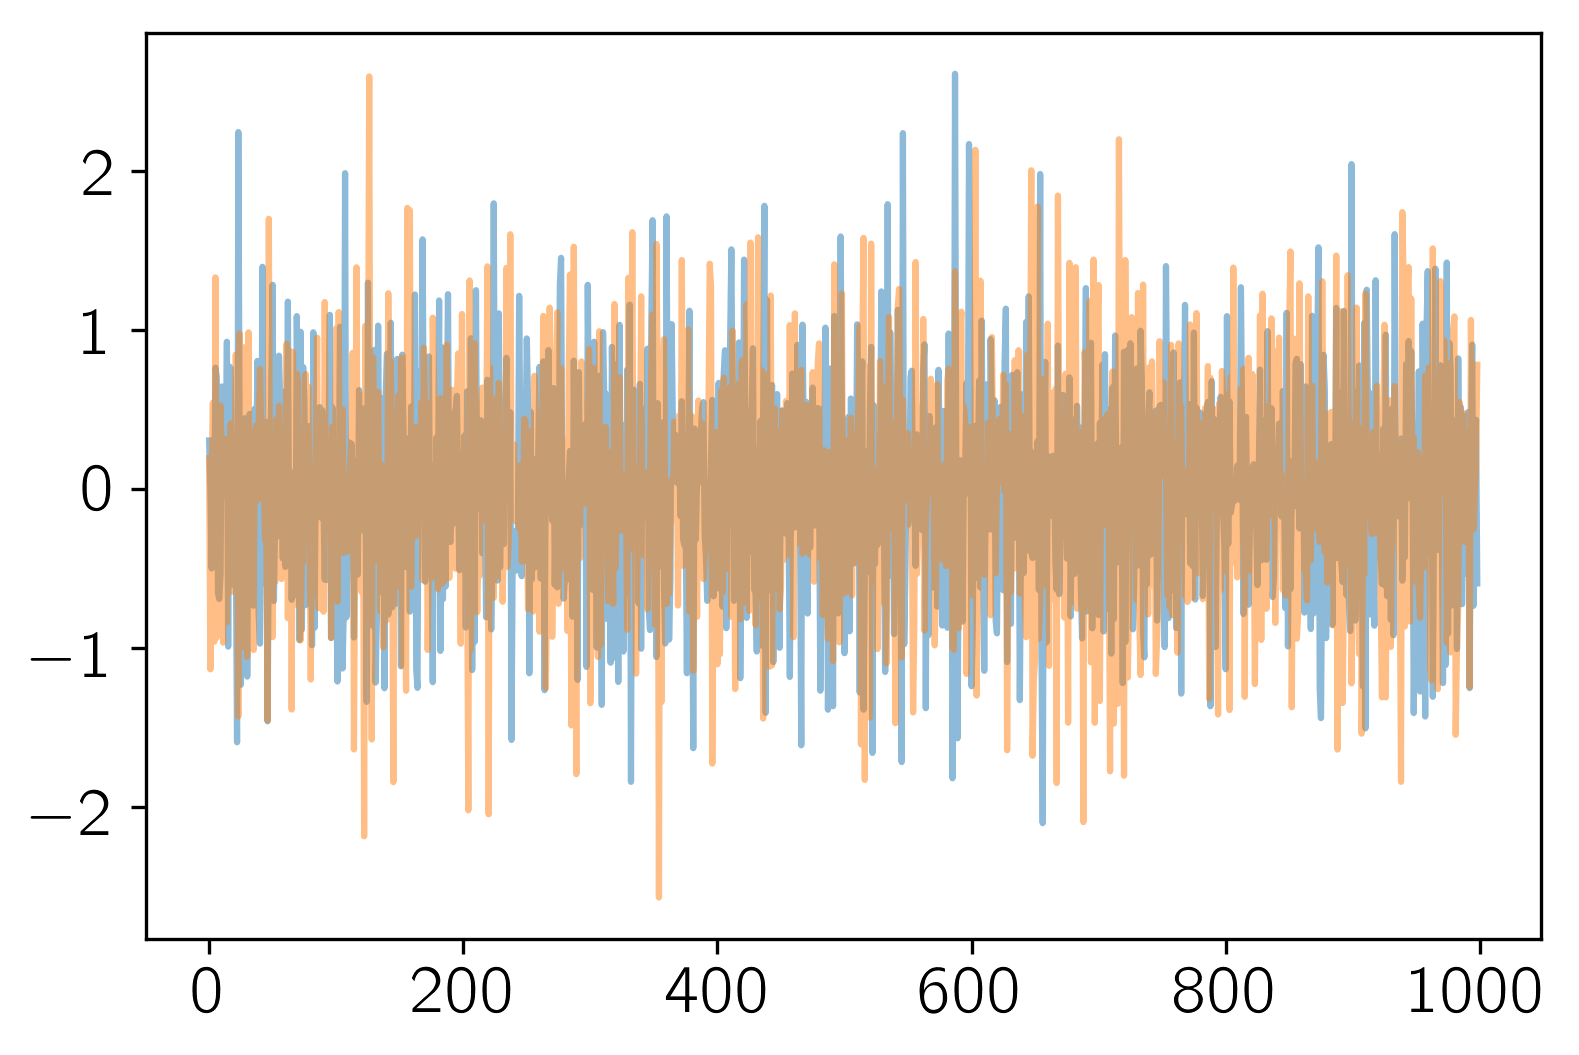

In [78]:
plot(diff(pinky),alpha=0.5);
plot(diff(pinky2),alpha=0.5);

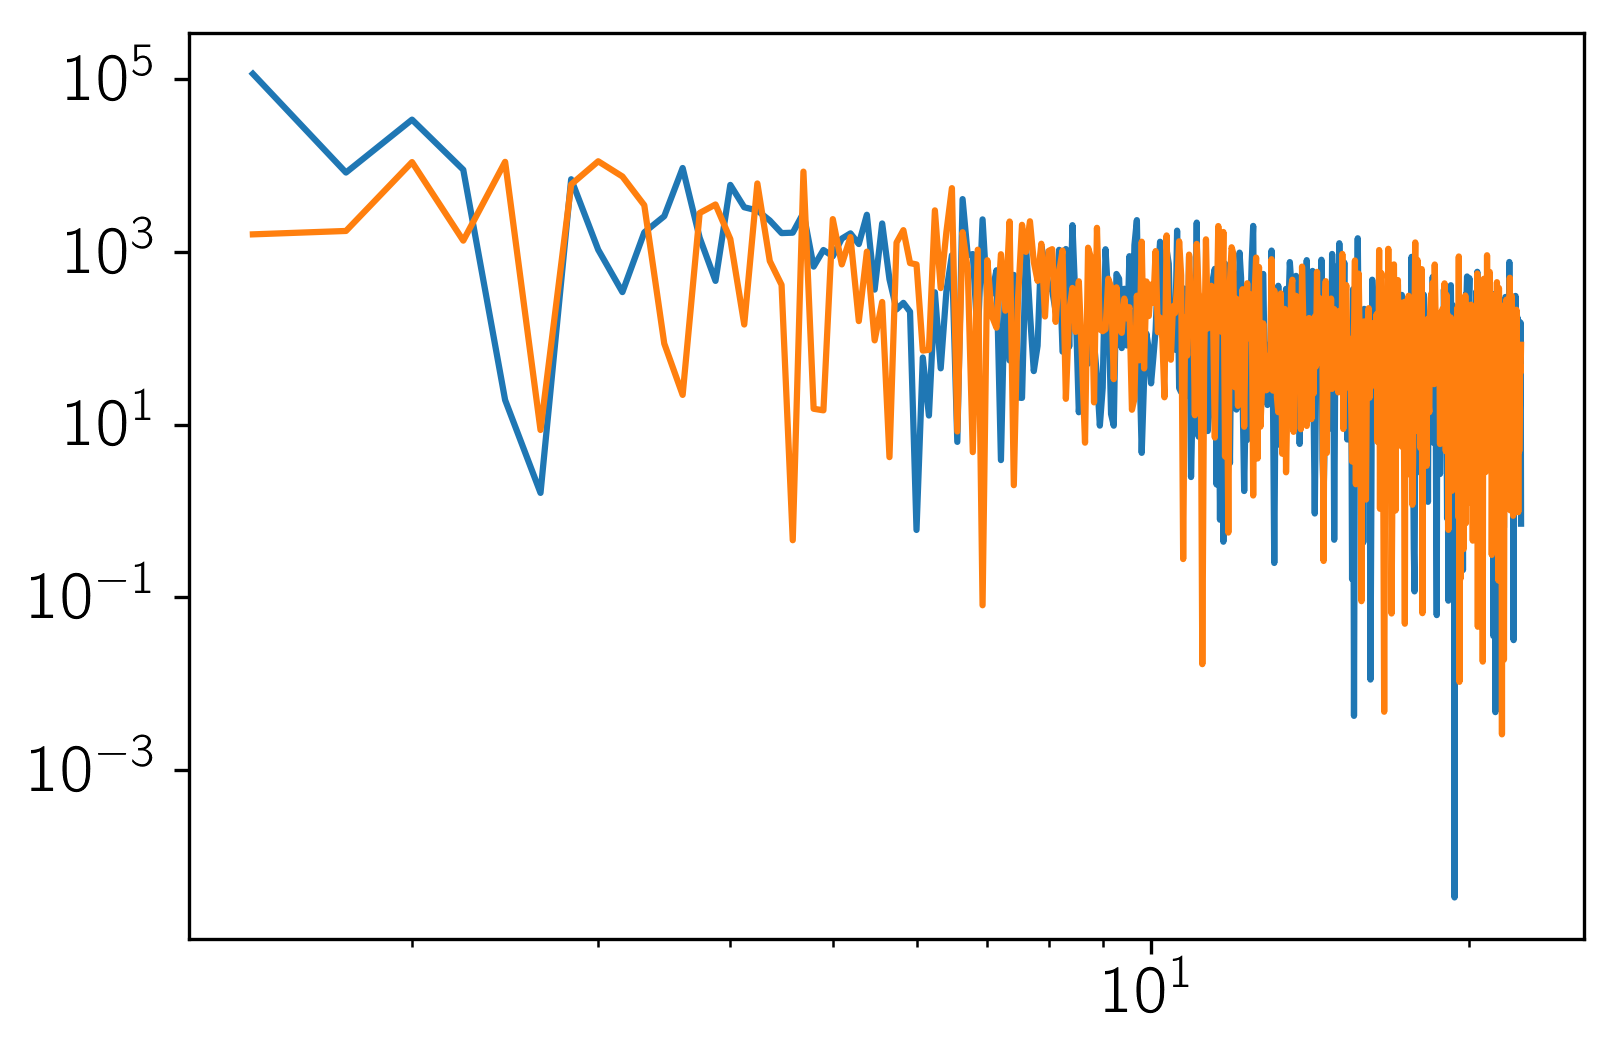

In [79]:
PSDinky = (np.fft.fftshift(np.fft.fft(pinky))[nPts//2:]).real**2
PSDinky2= (np.fft.fftshift(np.fft.fft(pinky2))[nPts//2:]).real**2
GSinky  = (np.fft.fftshift(np.fft.fft(ginky))[nPts//2:]).real**2
loglog(Sinky[1:],PSDinky);
loglog(Sinky[1:],PSDinky2);
# loglog(Sinky[1:],GSinky);

In [80]:
import celerite
from celerite import terms

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)

logS0Range = -15, 15
logQRange  = -15, 15
logOmRange = -15, 15

bounds = dict(log_S0=logS0Range, log_Q=logQRange, log_omega0=logOmRange)

# kernelReal = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)
# kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 0.3#.0
S0 = np.var(y) / (w0 * Q)
kernelSHO = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

kernel = kernelSHO #+ kernelReal

# # A periodic component
# Q = 1.0
# w0 = 3.0
# S0 = np.var(y) / (w0 * Q)
# kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
#                         bounds=bounds)

In [81]:
t    = tinky
y    = pinky #+ np.linspace(0,t.max(),pinky.size)
yerr = yerrinky

<Container object of 3 artists>

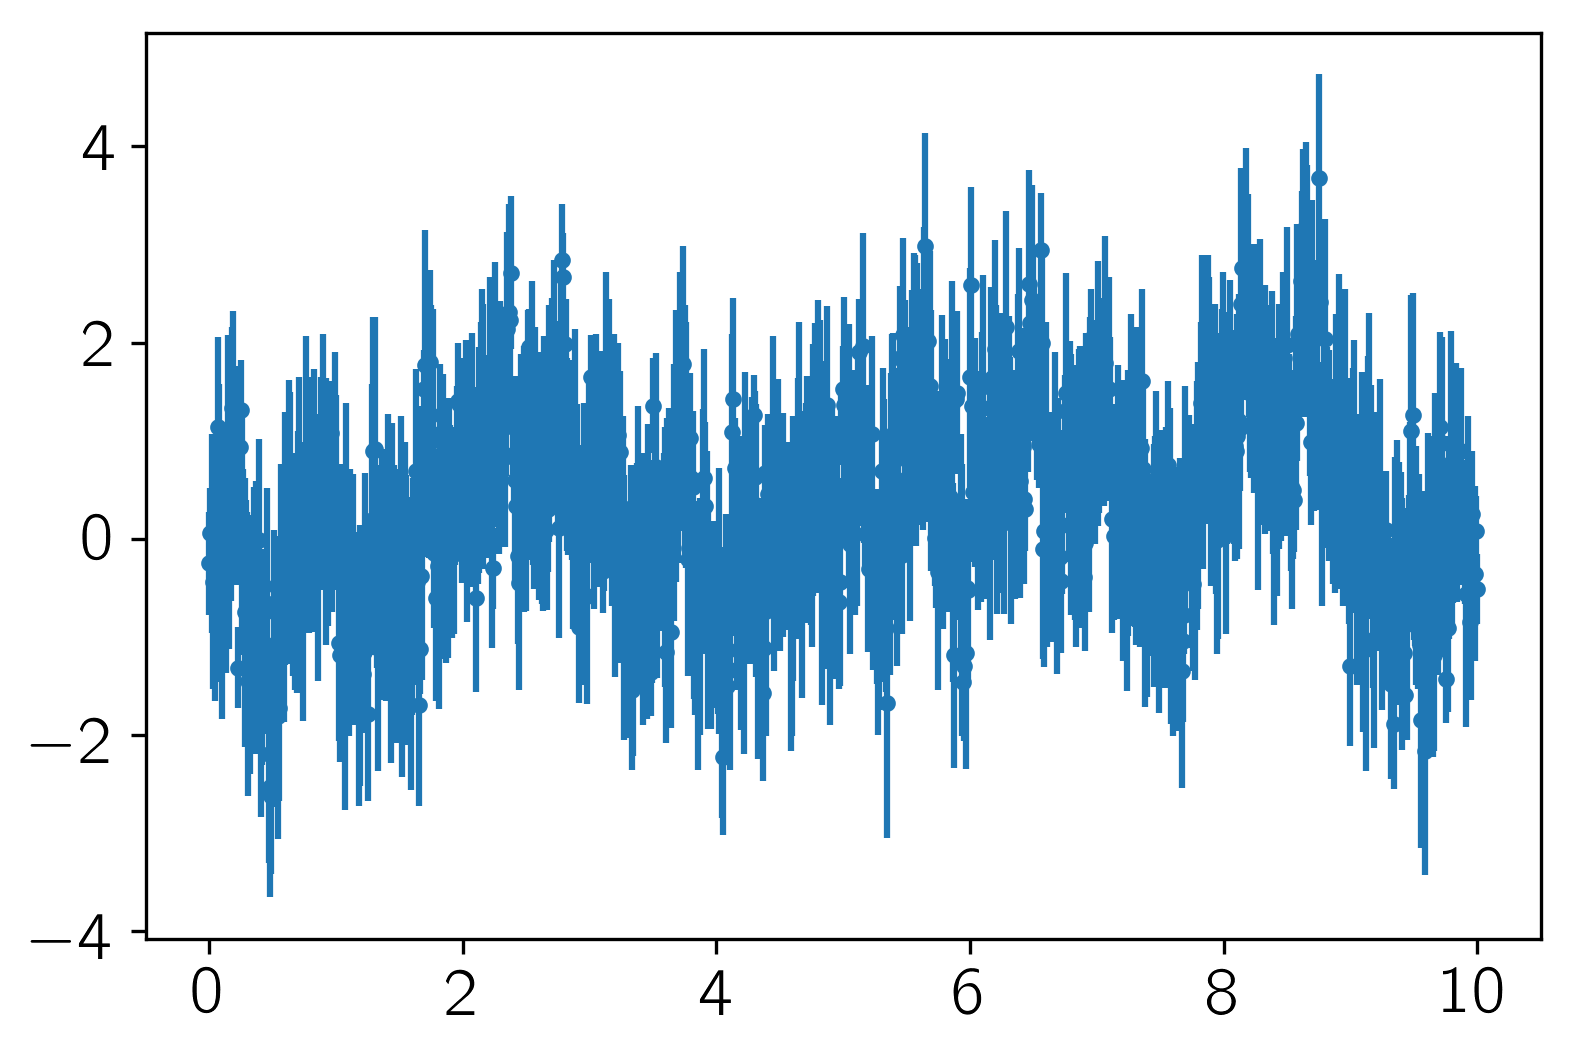

In [82]:
errorbar(t,y,yerr,fmt='.')

In [83]:
from scipy.optimize import minimize

cnt = 0
def neg_log_like(params, y, gp):
    global cnt
    cnt+=1
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

In [84]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
random_state  = 42
test_size     = 0.5

tTrain, tTest, yTrain, yTest, yerrTrain, yerrTest = train_test_split(t, y, yerr, test_size=test_size, random_state=random_state)

yTrain = yTrain[tTrain.argsort()]
yTest  = yTest[tTest.argsort()]

tTrain.sort()
tTest.sort()

In [85]:
gp = celerite.GP(kernel, mean=np.mean(yTrain))
gp.compute(tTrain, yerrTrain)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(yTrain)))

Initial log likelihood: -714.7424114041353


In [86]:
initial_params = gp.get_parameter_vector()
bounds         = gp.get_parameter_bounds()

start = time()
r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(yTrain, gp))
end = time()

gp.set_parameter_vector(r.x)
print()
print(r)
print()
print("Operation took {0:.2e} seconds and checked the LL {1:d} times".format(end-start, cnt))


      fun: 586.2100491993046
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.41060513e-05,   1.13686838e-05,   2.27373675e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 176
      nit: 24
   status: 0
  success: True
        x: array([-2.10241167, -1.53763567,  2.98285174])

Operation took 4.16e-02 seconds and checked the LL 176 times


In [87]:
gp.compute(tTest, yerrTest)

nPtsBIG = 5000
x = np.linspace(tTest.min(), tTest.max(), nPtsBIG)
pred_mean, pred_var = gp.predict(yTest, x, return_var=True)
pred_std = np.sqrt(pred_var)

print(np.isnan(pred_mean).sum())

0


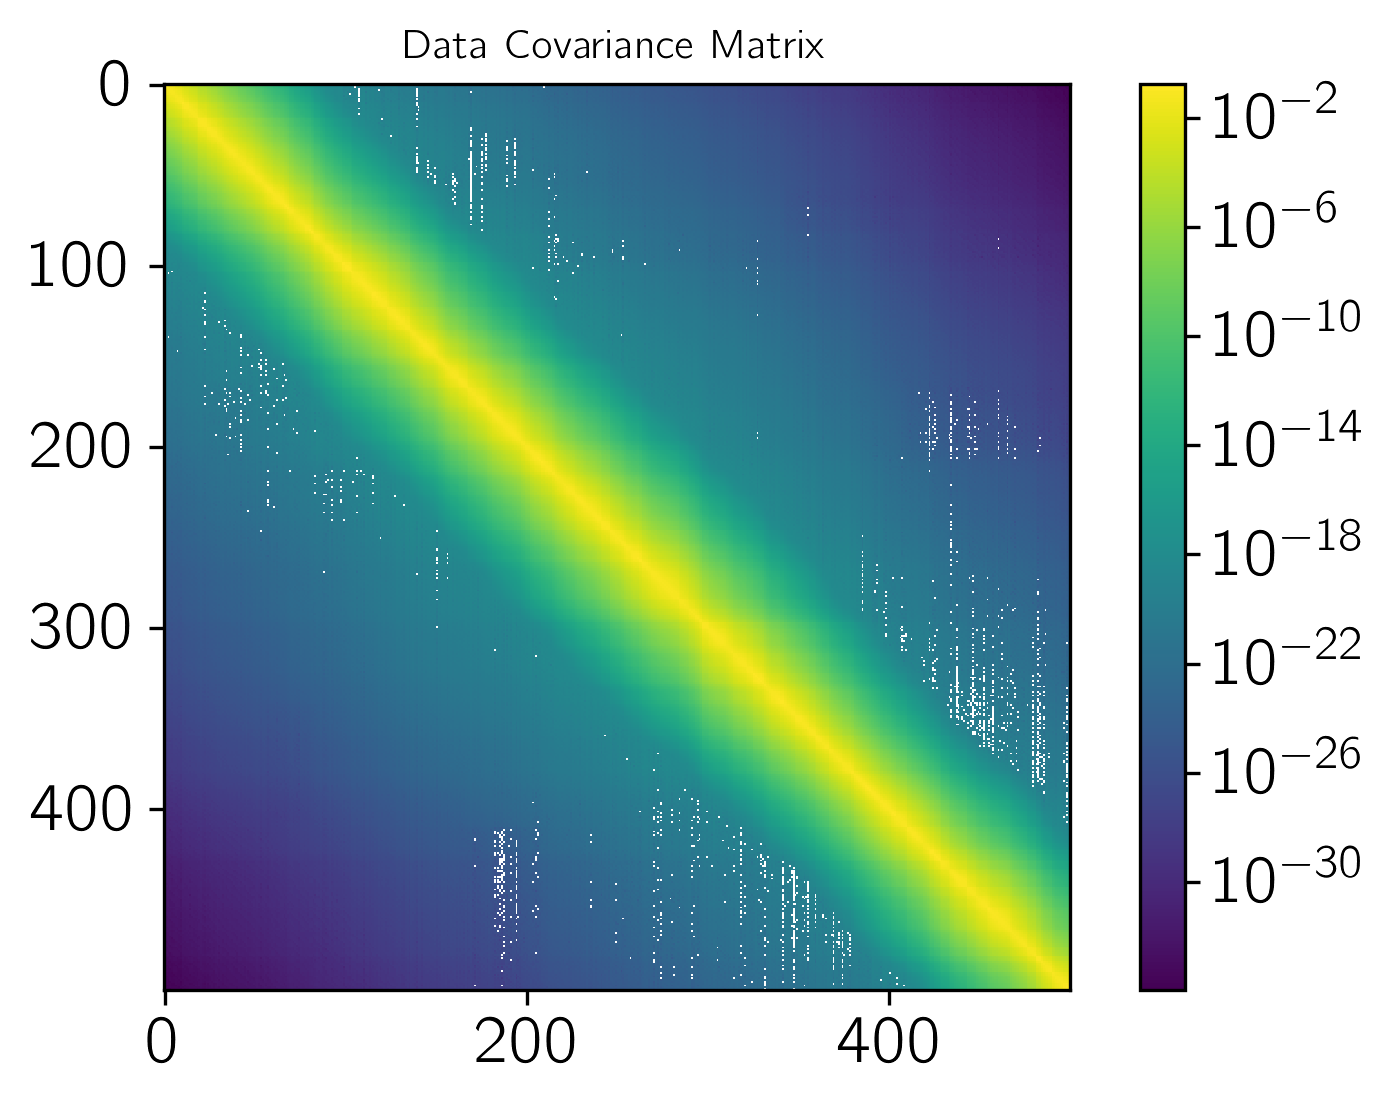

In [88]:
gp.compute(tTest, yerrTest)
pred_mean_Test2, pred_cov_Test2 = gp.predict(yTest, tTest)

imshow(pred_cov_Test2, norm=LogNorm());
title('Data Covariance Matrix',fontsize=10);
colorbar();

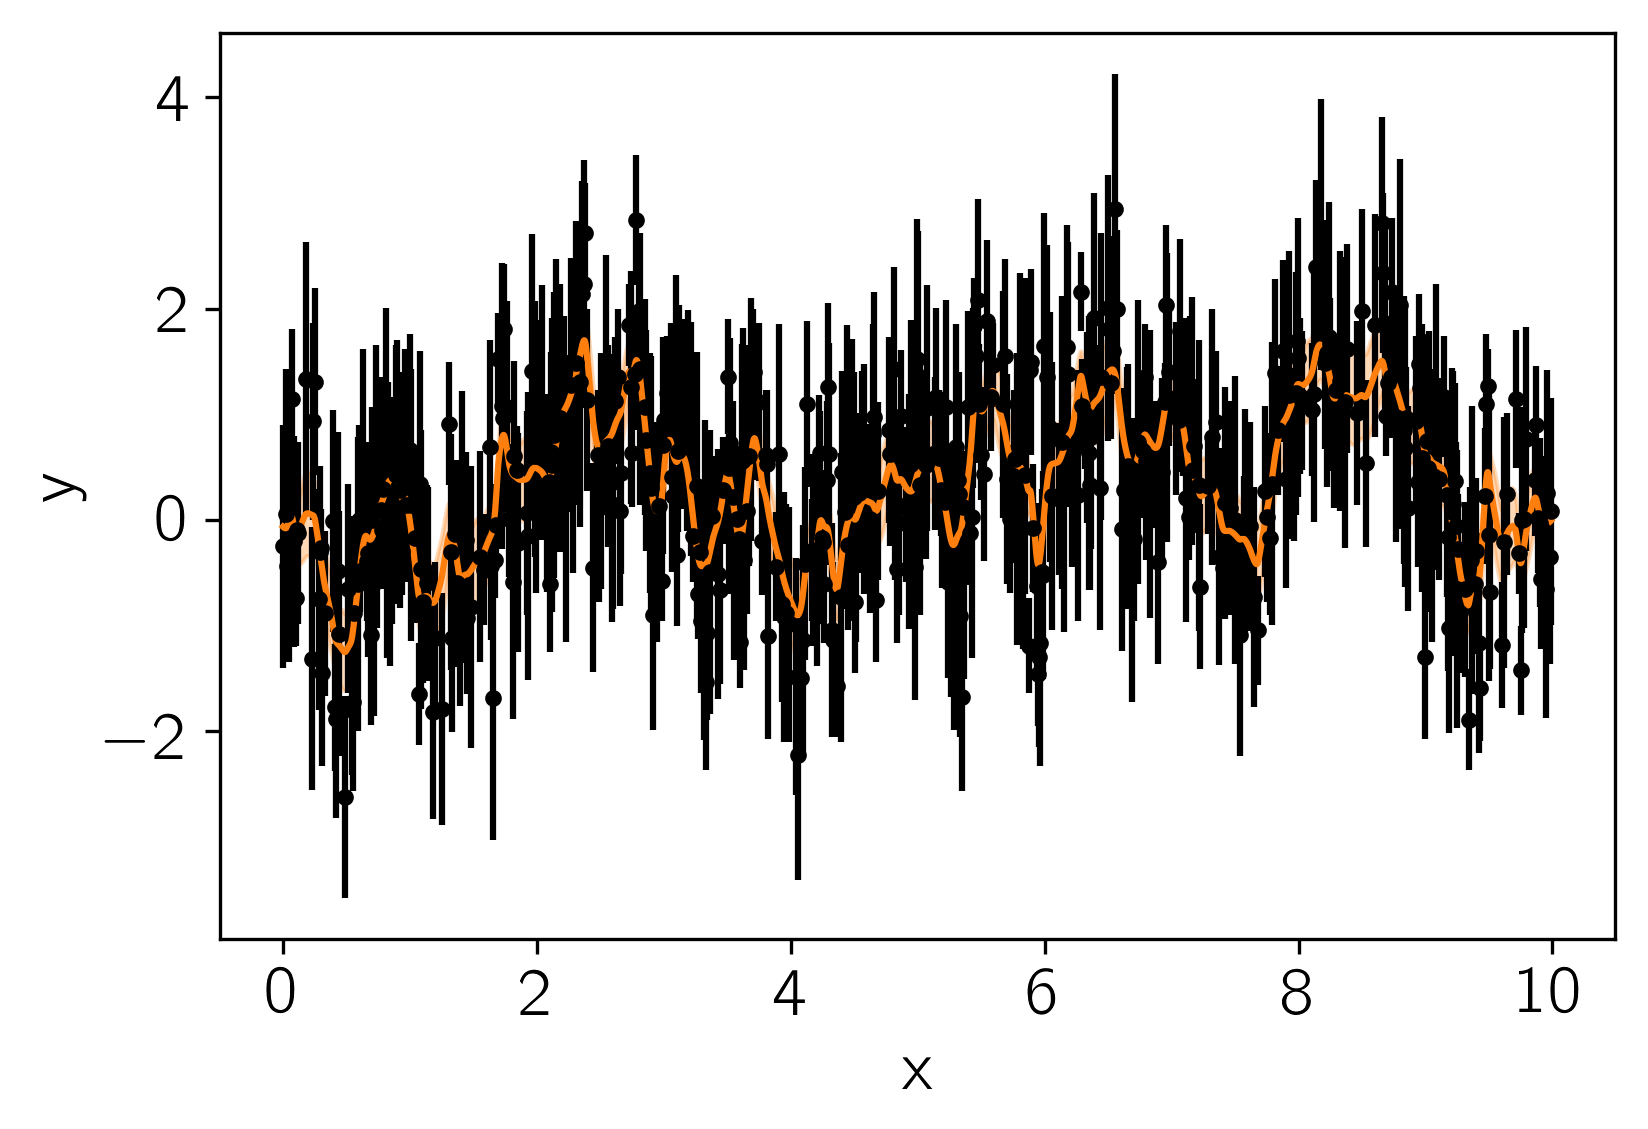

In [89]:
color = "#ff7f0e"
plt.errorbar(tTest, yTest, yerr=yerrTest, fmt=".k", capsize=0);
plt.plot(x, pred_mean, color=color);
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none");
plt.xlabel("x");
plt.ylabel("y");
# plt.xlim(0,10);
# plt.ylim(-2.5, 2.5);

**SciKit Learn Score Method**

$$R^2 = 1-\frac{u}{v}$$

with $T = y_{True}$ and $P = y_{Pred}$ such that

$$u = \sum_i^N (T_i - P_i)^2 \;\;\;\;\;\;\; \text{and} \;\;\;\;\;\;\;\; v = \sum_i^N (T_i - \bar{T})^2$$

The coefficient R^2 is defined as (1 - u/v), where u is the regression sum of squares ((y_true - y_pred)^2).sum() and v is the residual sum of squares ((y_true - y_true.mean())^2).sum(). Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

In [90]:
def sklearn_score(y_true, y_pred):
    u = ((y_true - y_pred)**2).sum()
    v = ((y_true - y_true.mean())**2).sum()
    return 1 - u/v

In [91]:
gp.compute(tTrain,yerrTrain)
pred_mean_Train, pred_var_Train = gp.predict(yTrain, tTrain, return_var=True)
pred_std_Train = sqrt(pred_var_Train)

gp.compute(tTest,yerrTest)
pred_mean_Test, pred_var_Test   = gp.predict(yTest, tTest, return_var=True)
pred_std_Test = sqrt(pred_var_Test)

gp.compute(tinky, yerrinky)
pred_mean_2, pred_var_2   = gp.predict(pinky2, tinky, return_var=True)
pred_std_2 = sqrt(pred_var_2)

randNoise = np.random.normal(0,pinkystd,tinky.size)
# gp.compute(tinky, yerrinky)
pred_mean_Rand, pred_var_Rand   = gp.predict(randNoise , tinky, return_var=True)
pred_std_Rand = sqrt(pred_var_Rand)

zerosArray = np.zeros(tinky.size)
# gp.compute(tinky, yerrinky)
pred_mean_Zero, pred_var_Zero   = gp.predict(zerosArray, tinky, return_var=True)
pred_std_Zero = sqrt(pred_var_Zero)

print("Training R^2 Score:", sklearn_score(yTrain, pred_mean_Train))
print("Test     R^2 Score:", sklearn_score(yTest, pred_mean_Test))
print("Pinky2   R^2 Score:", sklearn_score(pinky2, pred_mean_2))
print("Rando    R^2 Score:", sklearn_score(randNoise, pred_mean_Rand))
print("Zeros    R^2 Score:", sklearn_score(zerosArray, pred_mean_Zero))

Training R^2 Score: 0.679511334694
Test     R^2 Score: 0.603744688599
Pinky2   R^2 Score: 0.651990468094
Rando    R^2 Score: 0.110337805279
Zeros    R^2 Score: -inf


/Users/jfraine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


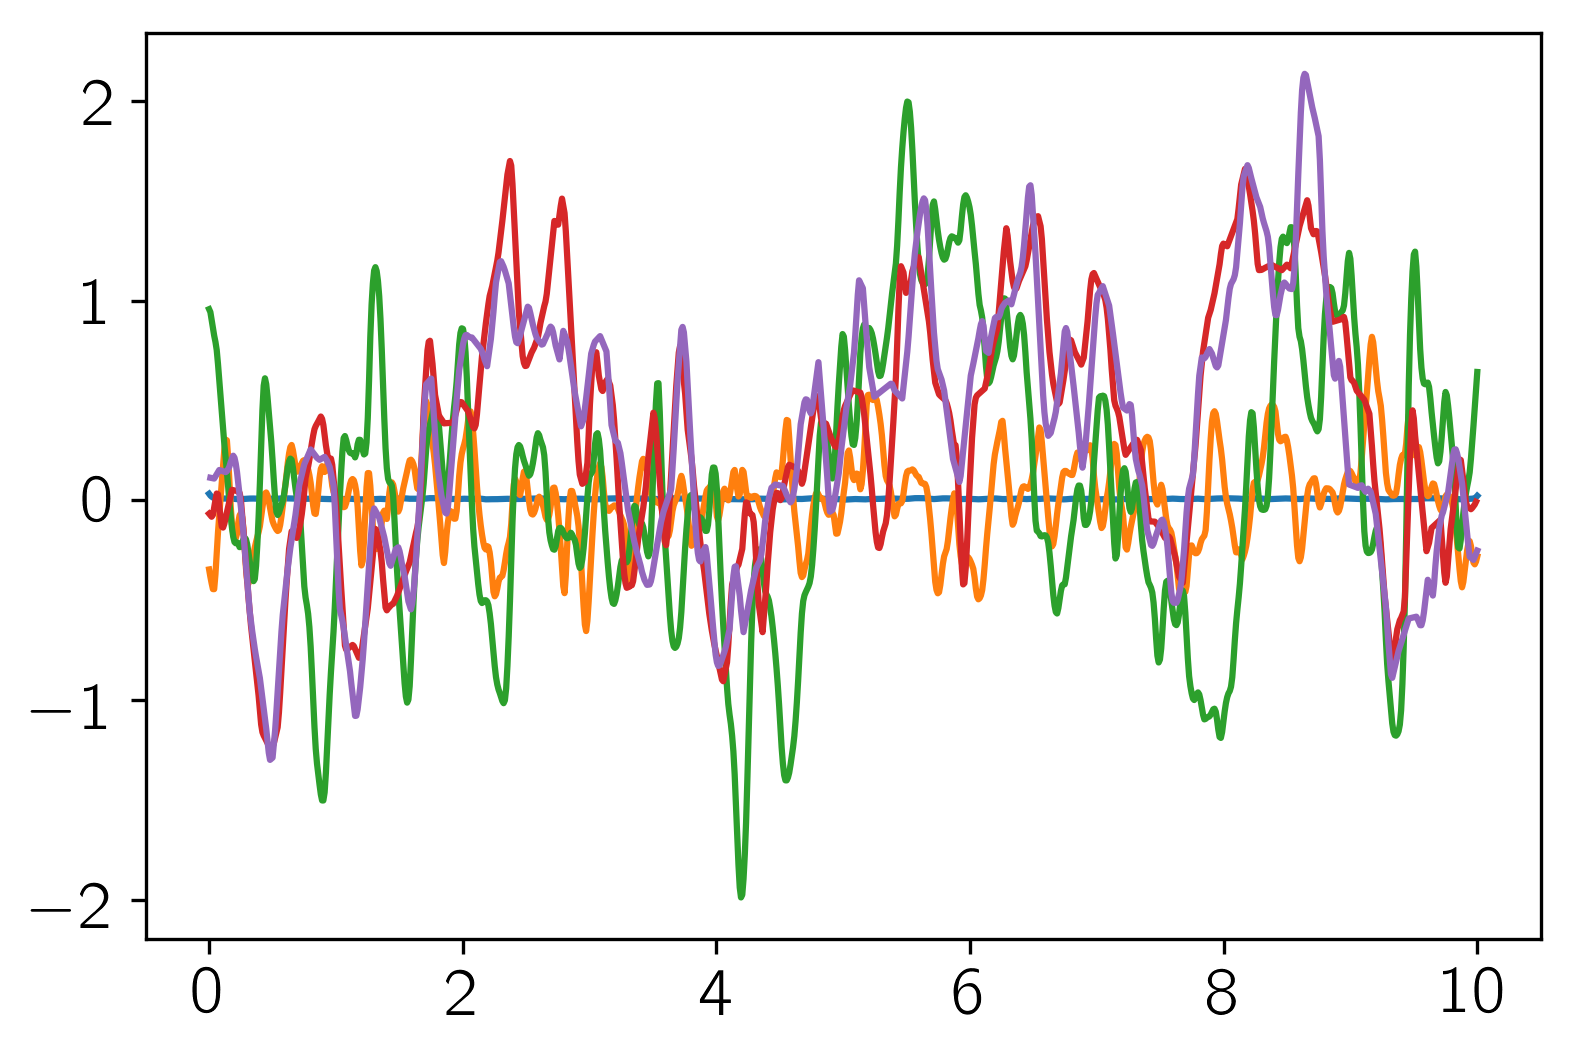

In [92]:
plot(tinky,pred_mean_Zero)
plot(tinky,pred_mean_Rand)
plot(tinky,pred_mean_2)
plot(tTest, pred_mean_Test)
plot(tTrain, pred_mean_Train)

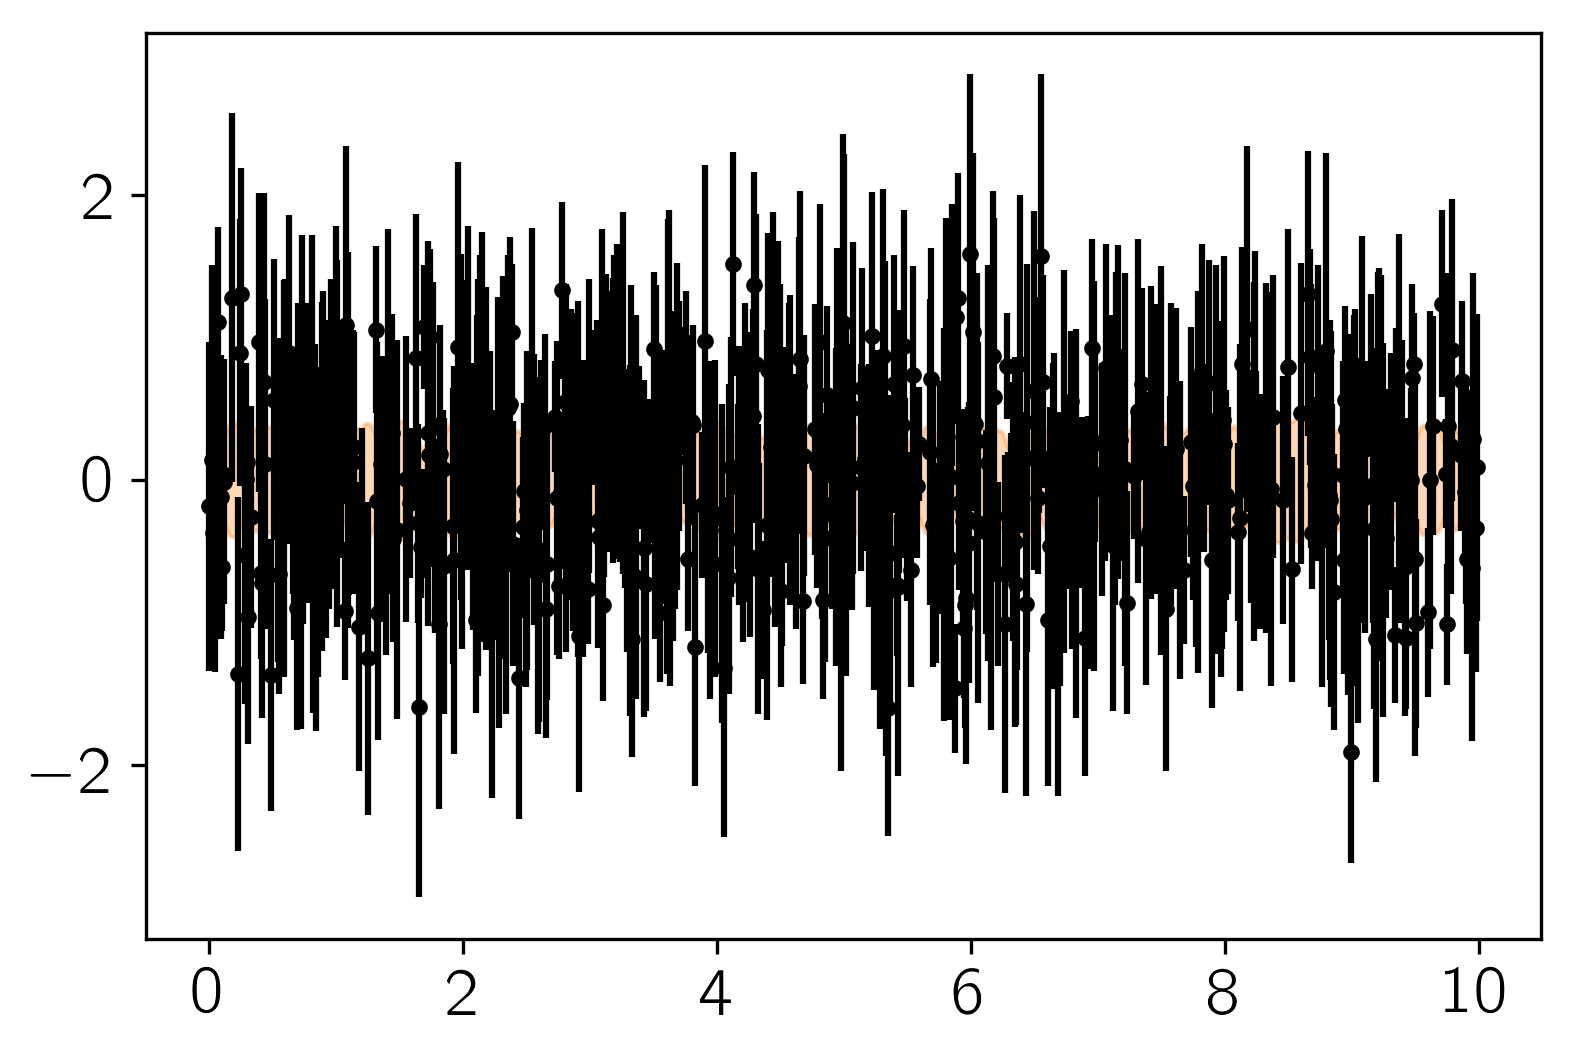

In [93]:
# pred_mean_data, pred_var_data = gp.predict(yTest, tTest, return_var=True)
plt.errorbar(tTest, yTest - pred_mean_Test, yerr=yerrTest, fmt=".k", capsize=0);
plt.fill_between(x, 0+pred_std, 0-pred_std, color=color, alpha=0.3, edgecolor="none");
# ylim(-2,2)
# xlim(0,2)

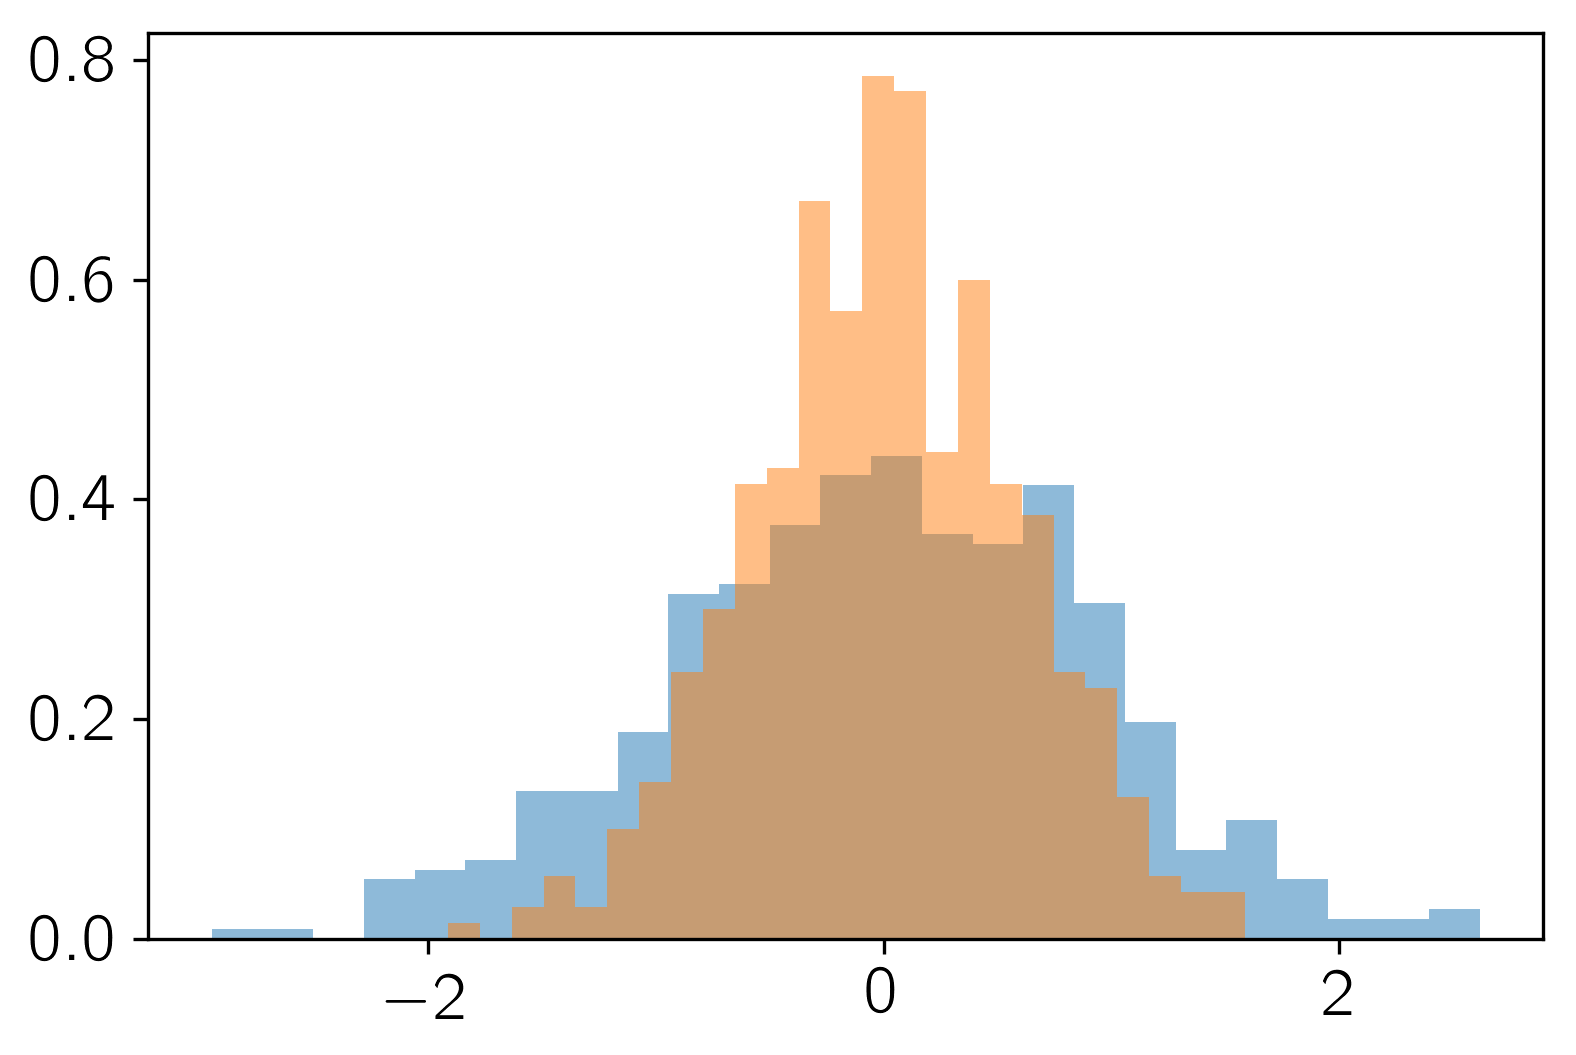

In [94]:
from astroML.plotting import hist
nbins = y.size//10
# hist(yTest-median(yTest), bins='blocks', normed=True, alpha=0.5);
# hist(yTest-pred_mean_Test, bins='blocks', normed=True, alpha=0.5);
hist(yTest-median(yTest), bins=tTest.size//20, normed=True, alpha=0.5);
hist(yTest-pred_mean_Test, bins=tTest.size//20, normed=True, alpha=0.5);

# xlim(-2,2);

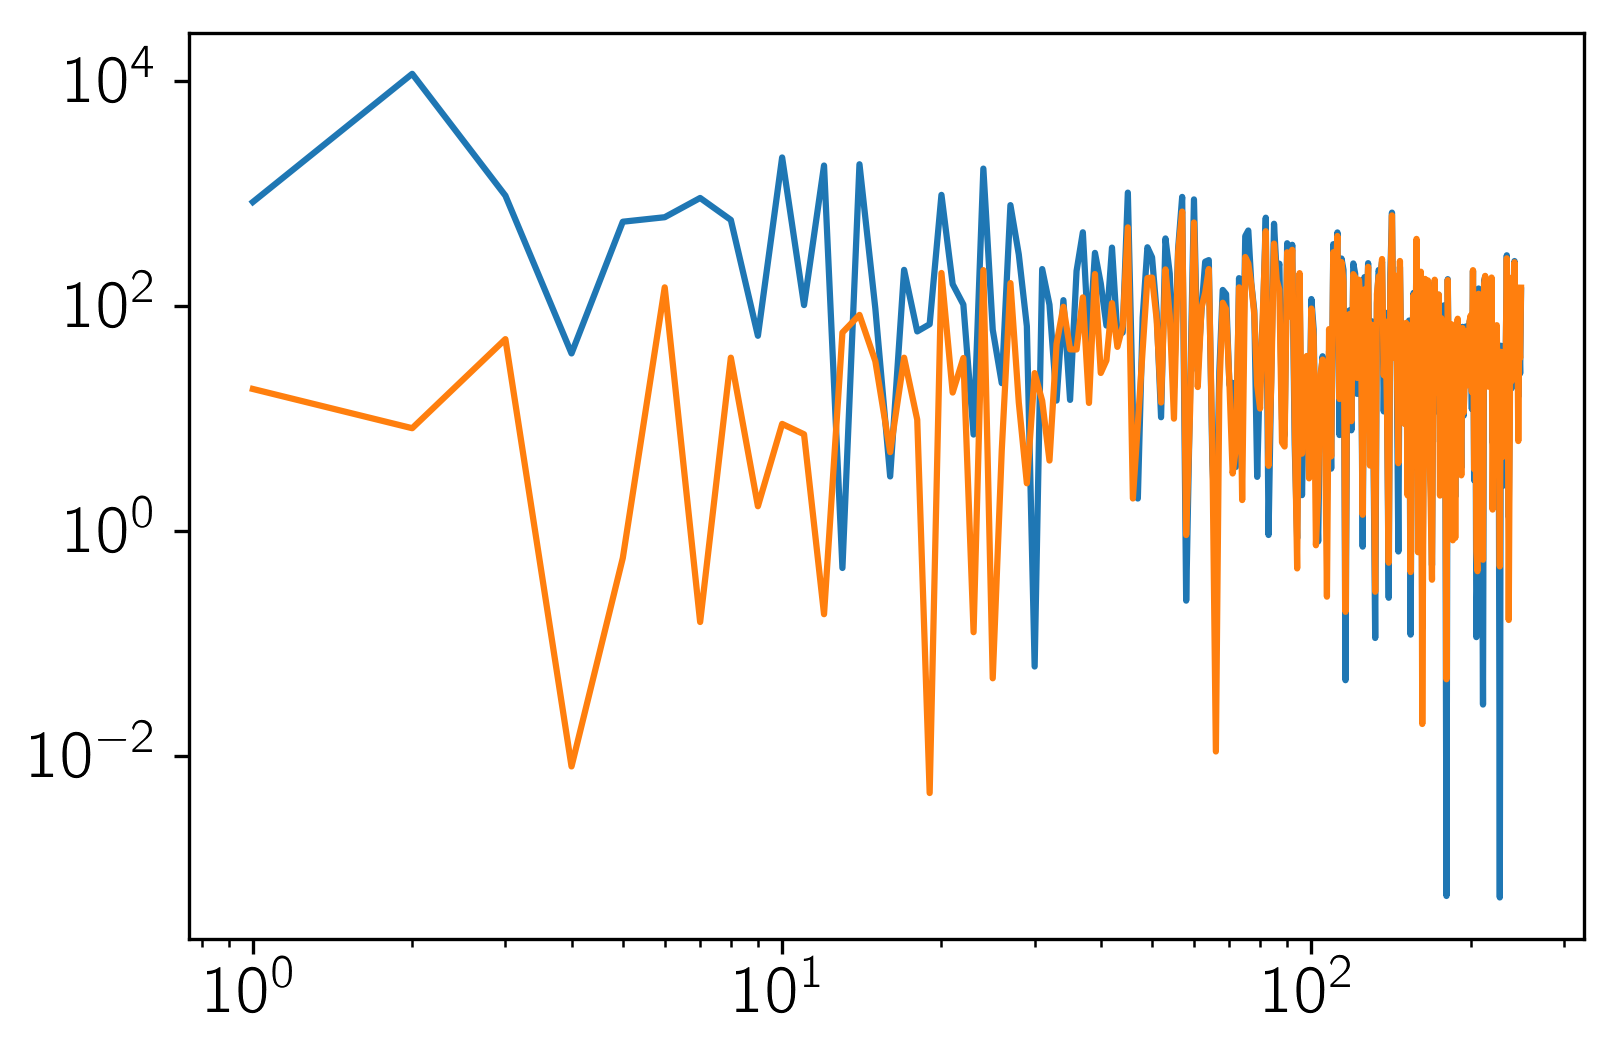

In [97]:
PSDinky = (np.fft.fftshift(np.fft.fft(yTest-median(yTest)))[yTest.size//2:]).real**2
PSDRes= (np.fft.fftshift(np.fft.fft(yTest - pred_mean_Test))[yTest.size//2:]).real**2
loglog(PSDinky);
loglog(PSDRes);

In [98]:
from scipy.stats import linregress

xlog    = np.log10(np.arange(PSDRes.size)+1.000001)
lr_res  = linregress(xlog, log10(PSDRes))
lr_init = linregress(xlog, log10(PSDinky))

print('init:\t\t', lr_init.slope, lr_init.intercept)
print('residuals:\t', lr_res.slope, lr_res.intercept)

init:		 -0.639038186 2.78057551661
residuals:	 0.280940842651 0.77383596867


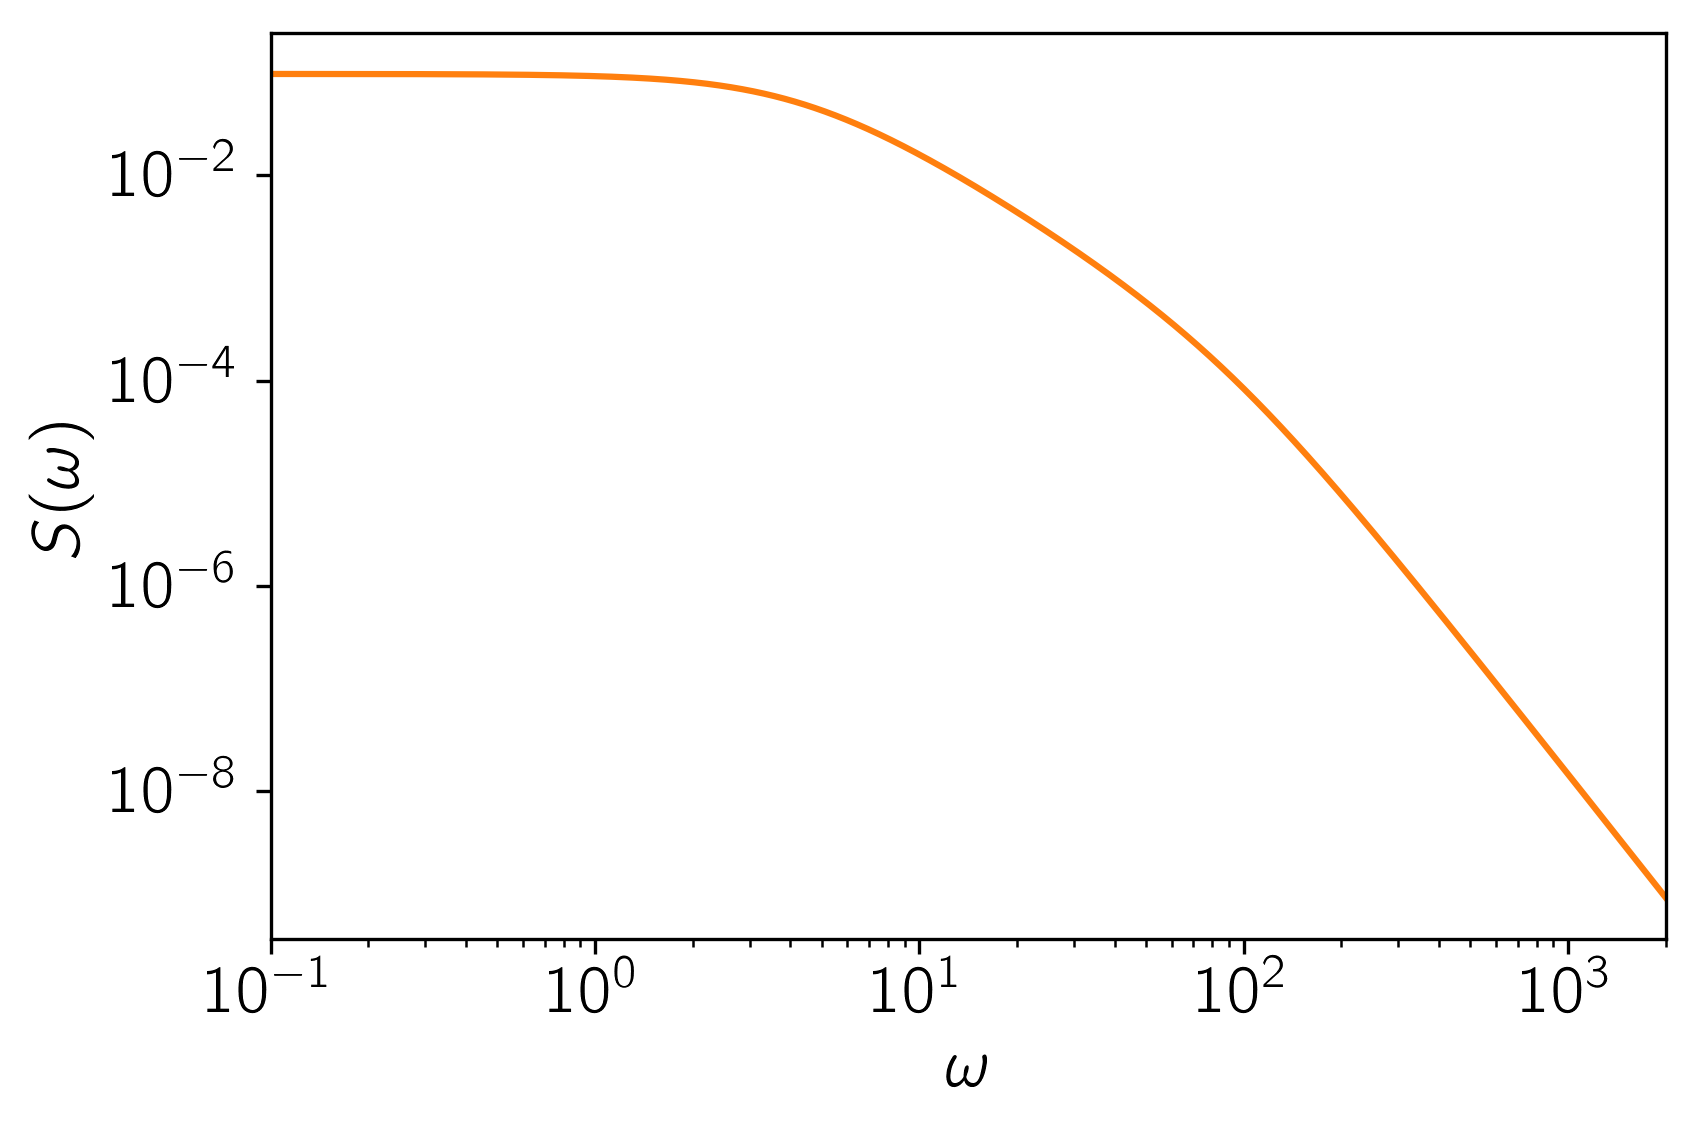

In [99]:
# from ExoWanderer.auxiliary import smooth_gaussconv

omega = np.exp(np.linspace(np.log(1e-1), np.log(2e3), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
# plt.plot(Sinky[1:PSDinky.size+1][:246],smooth_gaussconv(PSDinky/(PSDinky.size-1)**2,2)[:246]);
# for k in gp.kernel.terms:
#     plt.plot(omega, k.get_psd(omega), "--", color=color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");